In [1]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from sklearn.decomposition import PCA
from agents.networks.gru_rnn import GRU_RNN

AVERAGING_SIZE = 20

color_set_1 = [
    '#E4F1F7',
    '#C5E1EF',
    '#9EC9E2',
    '#6CB0D6',
    '#3C93C2',
    '#226E9C',
    '#0D4A70',
    '#054166',
]

color_set_2 = [
    '#F9D8E6',
    '#F2ACCA',
    '#ED85B0',
    '#E95694',
    '#E32977',
    '#C40F5B',
    '#8F003B',
    '#69022c',
]

HIDDEN_SIZE = 32
INPUT_SIZE = 1

In [98]:
hypo_data = [
    'line_attr_init_train_2024-12-14_18_34_50_046716_var_noise_5e-05_activity_weight_1e-07',
    'line_attr_init_train_2024-12-14_23_20_20_208670_var_noise_5e-05_activity_weight_1e-07',
    'line_attr_init_train_2024-12-15_09_56_13_820060_var_noise_5e-05_activity_weight_1e-07',
    'line_attr_init_train_2024-12-15_23_13_42_777248_var_noise_5e-05_activity_weight_1e-07',
]

ctrl_data = [
    'test_train_integrate_rnd_walk_2024-12-14_18_31_31_742859_var_noise_5e-05_activity_weight_1e-07',
    'test_train_integrate_rnd_walk_2024-12-14_23_20_12_932626_var_noise_5e-05_activity_weight_1e-07',
    'test_train_integrate_rnd_walk_2024-12-15_09_56_10_654082_var_noise_5e-05_activity_weight_1e-07',
    'test_train_integrate_rnd_walk_2024-12-15_23_13_43_477398_var_noise_5e-05_activity_weight_1e-07',
]

In [99]:
all_w_hh_trained = []

for i_d, d in enumerate(ctrl_data):

    network_trained = GRU_RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=1e-7,
    )
    
    load_path = f'../../results/line_attr_supervised/{d}/rnn_weights/029999.h5'
    network_trained.load_state_dict(torch.load(load_path, weights_only=True))
    
    w_hh_trained = network_trained.rnn.weight_hh.detach().numpy()
    all_w_hh_trained.append(w_hh_trained)

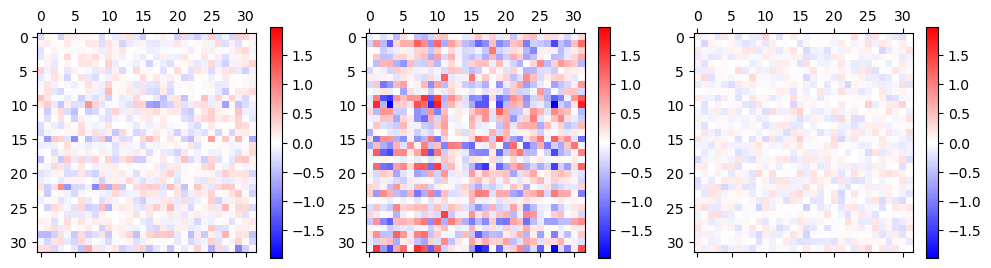

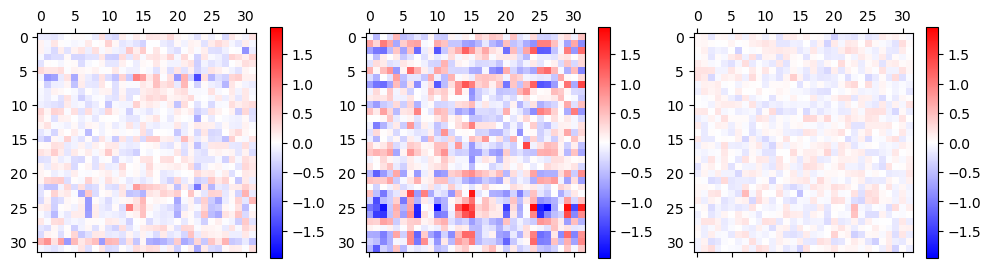

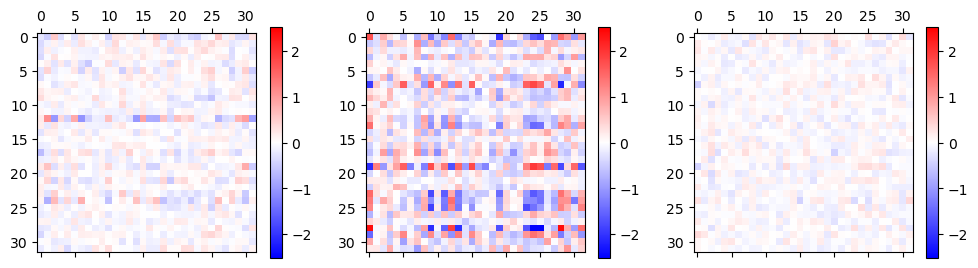

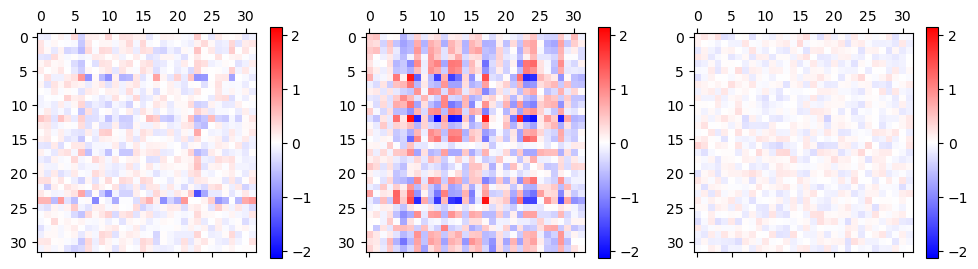

In [100]:
scale = 3

for w_hh_trained in all_w_hh_trained:
    fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
    
    m = np.abs(w_hh_trained).max()
    for k in range(3):
        cbar = axs[k].matshow(w_hh_trained[k * HIDDEN_SIZE:(k+1) * HIDDEN_SIZE], vmin=-m, vmax=m, cmap='bwr')
        plt.colorbar(cbar)

In [110]:
all_w_hh_trained = []
all_w_out = []
all_b_out = []

for i_d, d in enumerate(hypo_data):

    network_trained = GRU_RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=1e-7,
    )
    
    load_path = f'../../results/line_attr_supervised/{d}/rnn_weights/029999.h5'
    network_trained.load_state_dict(torch.load(load_path, weights_only=True))
    
    w_hh_trained = network_trained.rnn.weight_hh.detach().numpy()
    all_w_hh_trained.append(w_hh_trained)

    all_w_out.append(network_trained.output_arm.weight.detach().numpy())
    all_b_out.append(network_trained.output_arm.bias.detach().numpy())

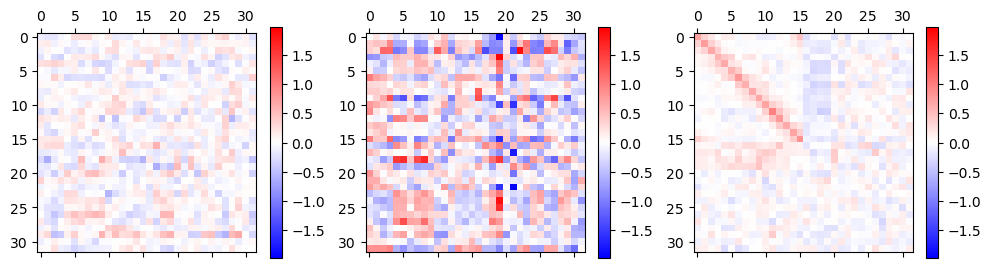

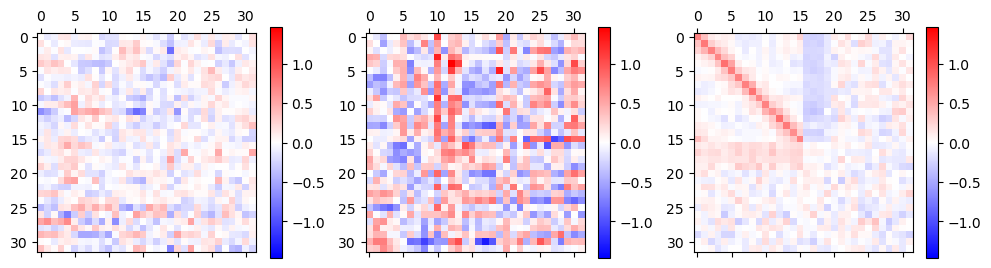

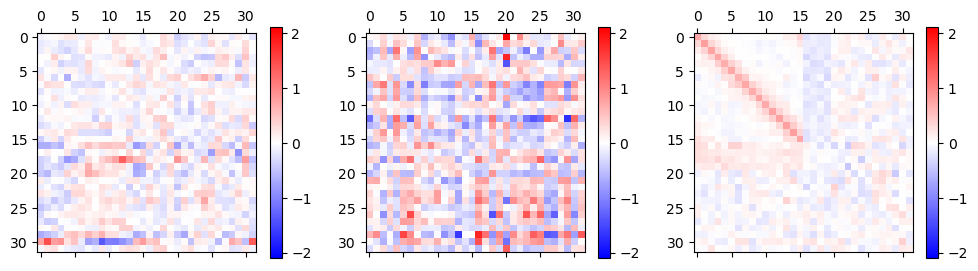

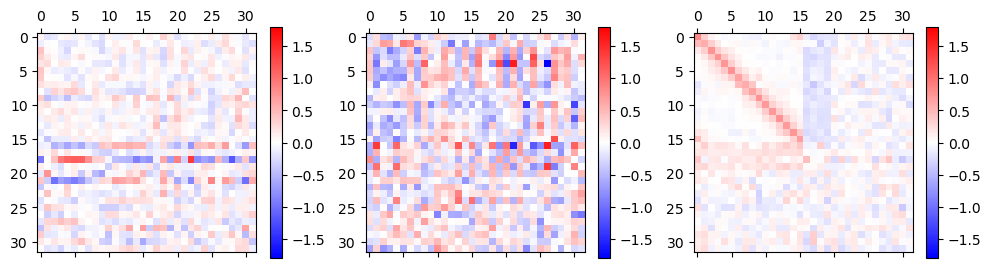

In [102]:
scale = 3

for w_hh_trained in all_w_hh_trained:
    fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
    
    m = np.abs(w_hh_trained).max()
    for k in range(3):
        cbar = axs[k].matshow(w_hh_trained[k * HIDDEN_SIZE:(k+1) * HIDDEN_SIZE], vmin=-m, vmax=m, cmap='bwr')
        plt.colorbar(cbar)

[array([0.1756141], dtype=float32), array([0.15530711], dtype=float32), array([0.25964928], dtype=float32), array([0.21158762], dtype=float32)]


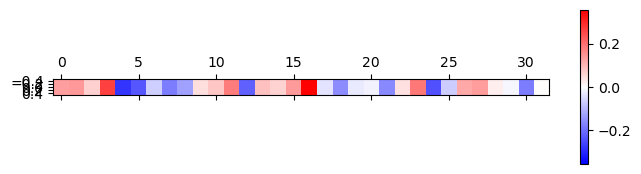

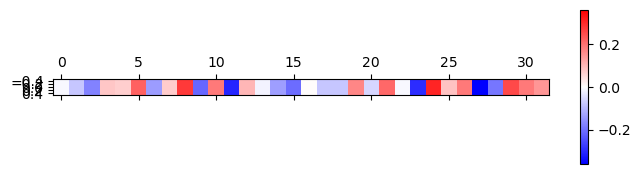

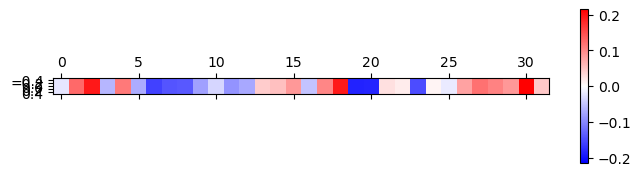

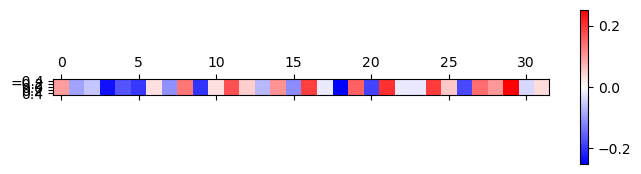

In [114]:
scale = 2

for w_out in all_w_out:
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 1 * scale))
    
    m = np.abs(w_out).max()
    cbar = axs.matshow(w_out, vmin=-m, vmax=m, cmap='bwr')
    plt.colorbar(cbar)

print(all_b_out)

In [3]:
def load_data(data_path, averaging_size=AVERAGING_SIZE):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.stack(data)
    data = data.flatten()
    
    return np.convolve(data, np.ones(averaging_size) / averaging_size, 'same')

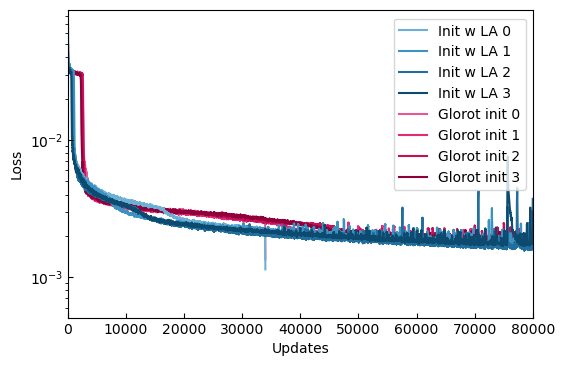

In [107]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

averaging_size = 100

for i_d, d in enumerate(hypo_data):
    data_dir = f'../../results/line_attr_supervised/{d}/losses'
    reduced_data = load_data(os.path.join(data_dir, '*.npy'), averaging_size=averaging_size)
    axs.plot(
        np.arange(reduced_data.shape[0]),
        reduced_data,
        c=color_set_1[i_d + 3],
        zorder=1,
        label=f'Init w LA {i_d}',
    )

for i_d, d in enumerate(ctrl_data):
    data_dir = f'../../results/line_attr_supervised/{d}/losses'
    reduced_data = load_data(os.path.join(data_dir, '*.npy'), averaging_size=averaging_size)
    
    axs.plot(
        np.arange(reduced_data.shape[0]),
        reduced_data,
        c=color_set_2[i_d + 3],
        zorder=0,
        label=f'Glorot init {i_d}',
    )


# axs.set_ylim(0)
axs.set_xlim(0, 80000)
axs.set_ylabel('Loss')
axs.set_xlabel('Updates')
axs.tick_params(axis='both', direction='in')
axs.set_yscale('log')
fig.legend(bbox_to_anchor=(0.9, 0.875))
print()

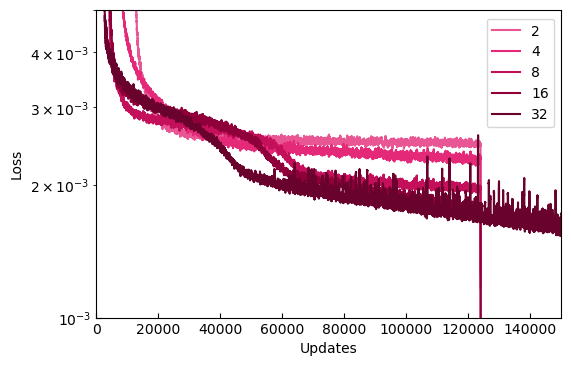

In [25]:
network_size_data = [
    'size_test_02_2024-12-18_18_32_30_128548_var_noise_5e-05_activity_weight_1e-07',
    'size_test_04_2024-12-18_18_32_46_767804_var_noise_5e-05_activity_weight_1e-07',
    'size_test_08_2024-12-18_18_33_23_169955_var_noise_5e-05_activity_weight_1e-07',
    'size_test_16_2024-12-18_18_34_09_701658_var_noise_5e-05_activity_weight_1e-07',
    'test_train_integrate_rnd_walk_2024-12-15_23_13_43_477398_var_noise_5e-05_activity_weight_1e-07',
]

scale = 1
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

averaging_size = 100

sizes = [2, 4, 8, 16, 32]

for i_d, d in enumerate(network_size_data):
    data_dir = f'../../results/line_attr_supervised/{d}/losses'
    reduced_data = load_data(os.path.join(data_dir, '*.npy'), averaging_size=averaging_size)
    axs.plot(
        np.arange(reduced_data.shape[0]),
        reduced_data,
        c=color_set_2[i_d + 3],
        zorder=1,
        label=f'{sizes[i_d]}',
    )

axs.set_ylim(1e-3, 5e-3)
axs.set_xlim(0, 150000)
axs.set_ylabel('Loss')
axs.set_xlabel('Updates')
axs.tick_params(axis='both', direction='in')
axs.set_yscale('log')
fig.legend(bbox_to_anchor=(0.9, 0.875))
print()